In [102]:
# !pip install nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('vader_lexicon')
# !pip install textblob
# !pip install wordcloud
# !pip install emoji
# !pip install transformers
# !pip install torch

In [103]:
import numpy as np
import pandas as pd
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from textblob import Word, TextBlob
from wordcloud import WordCloud  # visualization of words
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from warnings import filterwarnings
filterwarnings('ignore')

In [104]:
df = pd.read_csv(r'../data/reviews_raw_dataset.csv', encoding='utf-8') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   product_id   1000 non-null   int64 
 1   rating       1000 non-null   int64 
 2   review_text  1000 non-null   object
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


In [105]:
# Check the shape
df.shape

(1000, 3)

In [106]:
df.head()

,product_id,rating,review_text
0,108764,5,The addiction to this shampoo is made up of he...
1,108764,5,The smell is sweet. It is not good to use. Two...
2,108764,5,The smell is acceptable and good to use. I use...
3,108764,5,The shampoo is so bitter and its smell is swee...
4,108764,5,"The natural scent of herbs is pleasant, and ev..."


In [107]:
# Determine the number of unique elements of the dataset
df.nunique()

product_id        4
rating            5
review_text    1000
dtype: int64

In [108]:
# Determine whether there are missing values
df.isnull().sum()

product_id     0
rating         0
review_text    0
dtype: int64

# Text Preprocessing

In [109]:
# Function for converting emojis to their official description 
def emoji2description(text):
    def replace_with_space(emoji, data_dict):
        description = ' '.join(data_dict['en'].split('_')).strip(':')
        
        # Get the index of the emoji in the text
        index = text.find(emoji)
        
        # Get the previous and next characters
        prev_char = text[max(0, index-1)] if index > 0 else ''
        next_char = text[min(len(text), index+1)] if index < len(text)-1 else ''
        
        # Check if there is no whitespace before the emoji
        if not prev_char.isspace() and prev_char != '':
            description = ' ' + description
        # Check if there is no whitespace after the emoji
        if not next_char.isspace() and next_char != '':
            description += ' '
        
        return description
    
    # Replace emojis with descriptions
    return emoji.replace_emoji(text, replace=replace_with_space)

# Apply the function to the reviews 
df['review_text'] = df['review_text'].apply(emoji2description)

In [110]:
# Normalize text to lowercase letters
df['review_text'] = df['review_text'].str.lower()

In [111]:
# Replace unnecessary marks with spaces followed by a space, and replace those not followed by a space with a space
# Preserve exclamation and question marks for emotional and interrogative context
df['review_text'] = df['review_text'].apply(lambda x: re.sub(r'([,.:;@#\^&_\+\-\*/<>\(\)\{\}®=…])(?=\s)', '', re.sub(r'([,.:;@#\^&_\+\-\*/<>\(\)\{\}®=…])(?!\s)', ' ', x)))

In [112]:
# Remove stopwords that lack metrical meaning from the text
sw = stopwords.words('english') # The one for English from nltk library
df['review_text'] = df['review_text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [113]:
# Correct spelling in review texts using TextBlob
df['review_text'] = df['review_text'].apply(lambda x: str(TextBlob(x).correct()))

In [114]:
# Convert each word in 'review_text' to its base form using lemmatization
df['review_text'] = df['review_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [115]:
# Export the dataframe to a csv file
df.to_csv(r'../data/reviews_clean_dataset.csv', encoding='utf-8', index = False)

# Rating Distribution

In our analysis of the top-selling products over the past 30 days across four iHerb Hair Care categories—Shampoo, Conditioner, Treatments, and Styling—we have identified the market leaders from a selection of 11 prominent brands. Notably, the Shampoo, Conditioner, and Treatments categories are dominated by a single, cohesive product line from Mielle:

- Strengthening Shampoo, Rosemary Mint (product_id: 108764)
- Strengthening Conditioner, Rosemary Mint Blend (product_id: 124721)
- Scalp & Hair Strengthening Oil, Rosemary Mint (product_id: 110487)

The Styling category's best-seller, the L.A. Hold Styling Gel—Strong Hold (product_id: 6418), originates from a different brand, Giovanni.

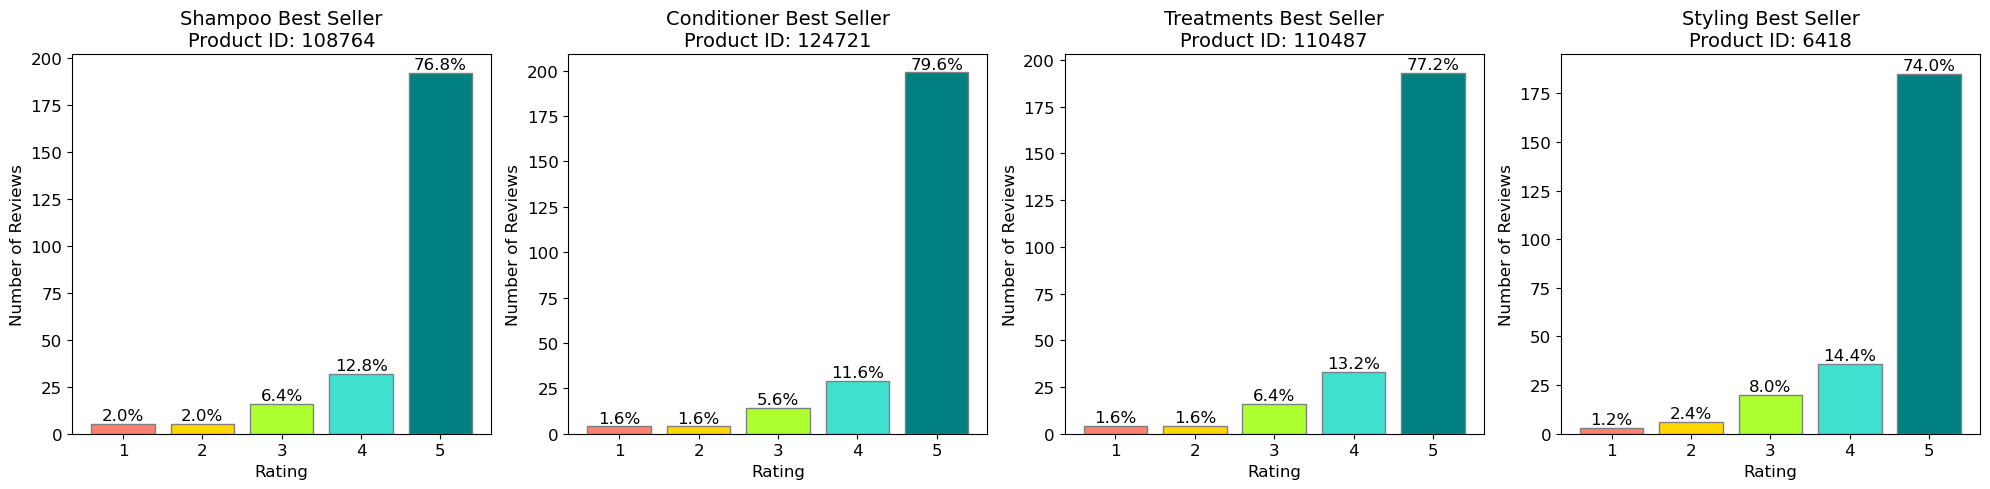

In [116]:
# List of product_ids to visualize
product_ids = [108764, 124721, 110487, 6418]

# Mapping of product_ids to their categories
product_categories = {
    108764: 'Shampoo Best Seller',
    124721: 'Conditioner Best Seller',
    110487: 'Treatments Best Seller',
    6418: 'Styling Best Seller'
}

colors = {1: 'salmon', 2: 'gold', 3: 'greenyellow', 4: 'turquoise', 5: 'teal'}
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

label_fontsize = 12
title_fontsize = 14
tick_fontsize = 12

for ax, product_id in zip(axes, product_ids):
    product_data = df[df['product_id'] == product_id]
    
    # Count the frequency of each rating
    rating_counts = product_data['rating'].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)
    total_reviews = product_data.shape[0]
    
    # Plot bar chart
    bars = ax.bar(rating_counts.index, rating_counts, color=[colors[rating] for rating in rating_counts.index], edgecolor='grey')
    
    ax.set_title(f'{product_categories[product_id]}\nProduct ID: {product_id}', fontsize=title_fontsize)
    
    ax.set_xlabel('Rating', fontsize=label_fontsize)
    ax.set_ylabel('Number of Reviews', fontsize=label_fontsize)
    
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    
    ax.set_xticks(rating_counts.index)
    ax.set_xticklabels(rating_counts.index, fontsize=tick_fontsize)
    
    ax.set_ylim(0, max(rating_counts.max() + 10, 1))
    
    # Calculate the percentage for each rating and display it on top of the bars
    for bar in bars:
        percentage = (bar.get_height() / total_reviews) * 100
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=tick_fontsize, color='black')

plt.tight_layout()
plt.show()

# Word Clouds by Rating

We plan to conduct a collective analysis for the best sellers under the Shampoo, Conditioner, and Treatments categories coming from the same brand and product line, while examining the Styling product individually. To visualize the sentiments, we will generate word clouds for these two groups, with each set comprising three distinct clouds corresponding to the rating scales: (i) 4 to 5, (ii) 3, and (iii) 1 to 2.

In [117]:
# Function for generating word clouds
def generate_word_cloud(df, product_ids, ratings):
    # Filter the reviews for the specified product_ids and ratings
    product_reviews = df[df['product_id'].isin(product_ids) & df['rating'].isin(ratings)]

    # Check if the resulting dataFrame is not empty
    if not product_reviews.empty:
        # Preprocess the text to remove standalone 'hair' but keep 'hair loss'
        def custom_process_text(text):
            # Use a regular expression to remove 'hair' only if it's not part of 'hair loss'
            text = re.sub(r'\bhair\b(?!\s+loss)', '', text)
            # Remove any extra spaces
            text = re.sub(r'\s+', ' ', text).strip()
            return text

        product_reviews['processed_text'] = product_reviews['review_text'].apply(custom_process_text)
        product_reviews_text = ' '.join(product_reviews['processed_text'])

        # Define a list of already-known stopwords to exclude from the word clouds
        stopwords = set(WordCloud().stopwords).union({
            'use', 'using', 'used', 'shampoo', 'conditioner', 'conditioned', 'oil', 'gel', 'hairs',
            'scalp', 'product', 'products', 'feel', 'feeling', 'review', 'reviews', 'fire', 'red heart', 's', 't'
        })

        # Create a WordCloud object
        wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(product_reviews_text)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Turn off the axis
        plt.show()
    else:
        print("No reviews found for the specified product_ids and ratings.")

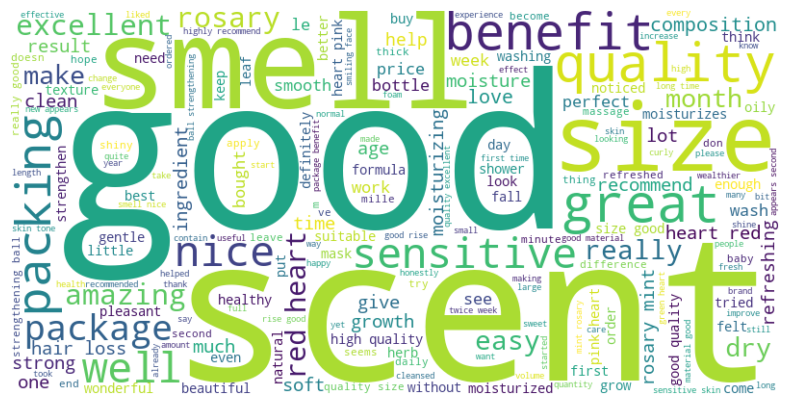

In [118]:
generate_word_cloud(df, [108764, 124721, 110487], [4, 5])

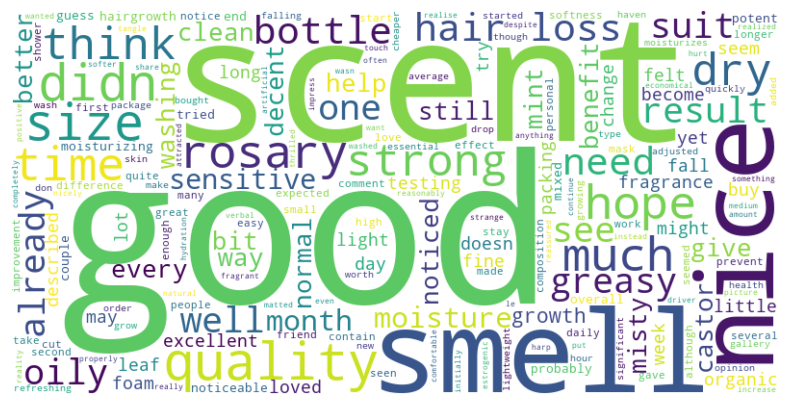

In [119]:
generate_word_cloud(df, [108764, 124721, 110487], [3])

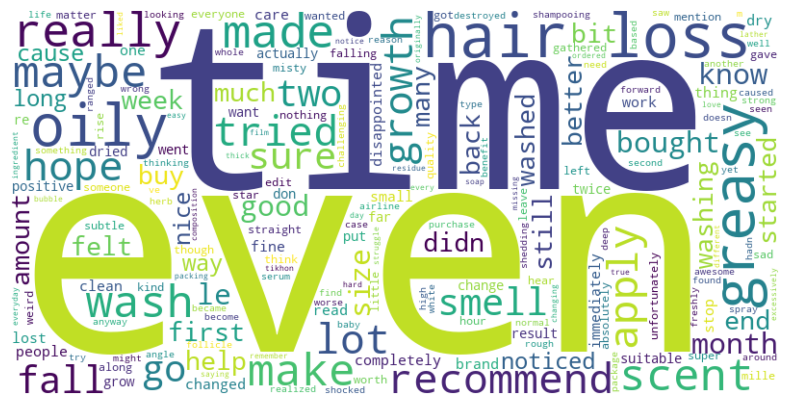

In [120]:
generate_word_cloud(df, [108764, 124721, 110487], [1, 2])

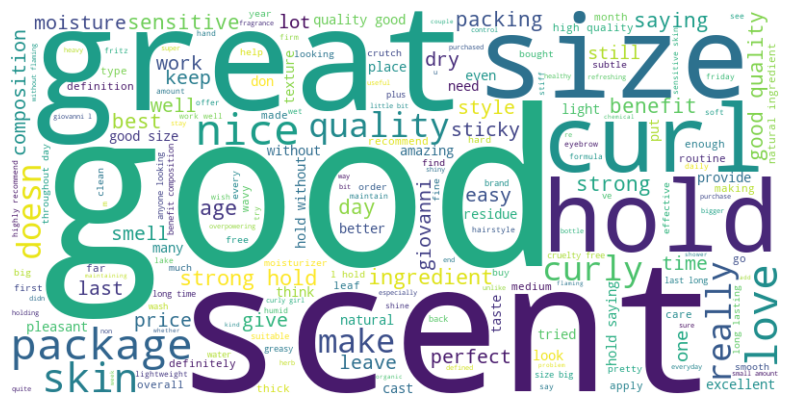

In [121]:
generate_word_cloud(df, [6418], [4, 5])

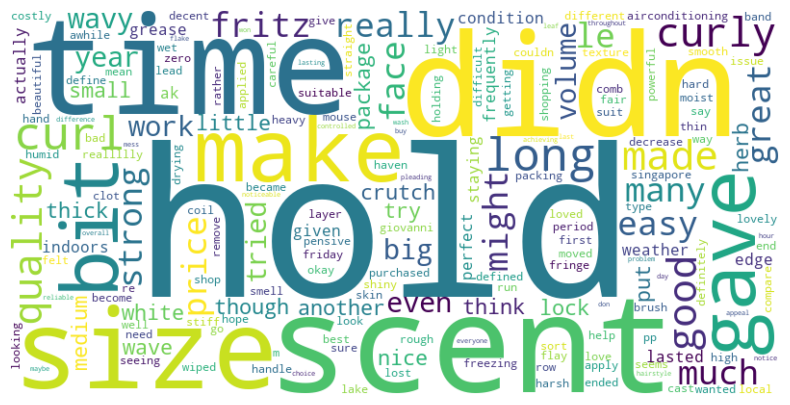

In [122]:
generate_word_cloud(df, [6418], [3])

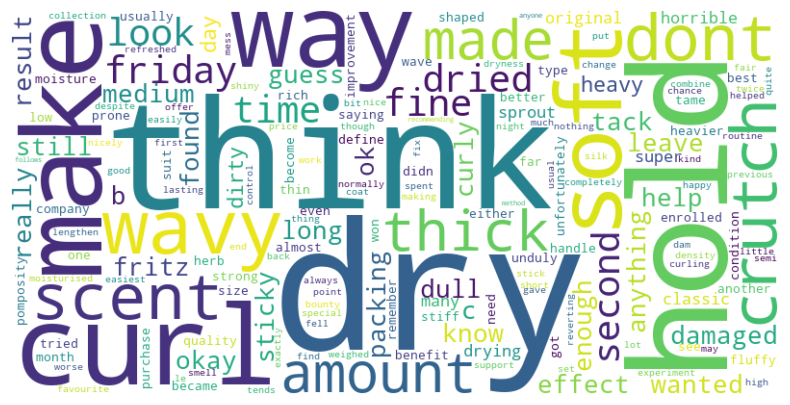

In [123]:
generate_word_cloud(df, [6418], [1, 2])

# Sentiment Analysis using VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool attuned to social media text. It provides scores for negative, neutral, and positive sentiments (the proportion of text that falls into each category which sums up to 1), along with a compound score indicating overall sentiment intensity, ranging from -1 to +1. These clear metrics facilitate straightforward interpretation and categorization of text sentiment.

Unexpectedly, we discovered that VADER's effectiveness on preprocessed text falls short of our expectations, especially when scoring sentiments of reviews that have been rated 1 to 2. To understand this discrepancy, we intend to compare VADER's performance under conditions with and without text preprocessing.

## With Text Preprocessing

In [124]:
sia = SentimentIntensityAnalyzer()

# Using the dataframe having textually preprocessed
vader1 = pd.DataFrame()

# Add columns for sentiment analysis results
vader1['vader_neg'] = None
vader1['vader_neu'] = None
vader1['vader_pos'] = None
vader1['vader_compound'] = None

# Perform sentiment analysis and store the results
for index, row in tqdm(df.iterrows(), total=len(df)):
    scores = sia.polarity_scores(row['review_text'])
    vader1.at[index, 'vader_neg'] = scores['neg']
    vader1.at[index, 'vader_neu'] = scores['neu']
    vader1.at[index, 'vader_pos'] = scores['pos']
    vader1.at[index, 'vader_compound'] = scores['compound']

# Import the original reivew text for comparison
df2 = pd.read_csv(r'../data/reviews_raw_dataset.csv', encoding='utf-8')

merged_vader1 = pd.concat([df, vader1], axis=1)
insert_position = len(df.columns)-1
merged_vader1.insert(insert_position, 'original_text', df2['review_text'])
merged_vader1.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,product_id,rating,original_text,review_text,vader_neg,vader_neu,vader_pos,vader_compound
0,108764,5,The addiction to this shampoo is made up of he...,addition shampoo made hers fell love bought se...,0.029,0.604,0.367,0.9747
1,108764,5,The smell is sweet. It is not good to use. Two...,smell sweet good use two squeezed enough lot f...,0.0,0.62,0.38,0.936
2,108764,5,The smell is acceptable and good to use. I use...,smell acceptable good use use twice week stron...,0.0,0.579,0.421,0.9643
3,108764,5,The shampoo is so bitter and its smell is swee...,shampoo bitter smell sweet sweet improves smel...,0.104,0.43,0.466,0.9432
4,108764,5,"The natural scent of herbs is pleasant, and ev...",natural scent hers pleasant even though i'm wa...,0.038,0.63,0.332,0.9711


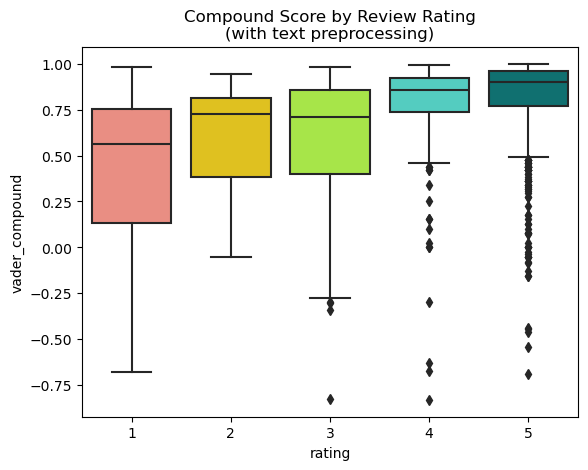

In [125]:
# Create the boxplot with the specified colors
ax = sns.boxplot(data=merged_vader1, x='rating', y='vader_compound', palette=colors)
ax.set_title('Compound Score by Review Rating\n(with text preprocessing)')
plt.show()

In [126]:
# Query the dataFrame for reviews with a 1-star rating and sort by the positive sentiment score in descending order
positive_1_star_vader1 = merged_vader1.query('rating == 1').sort_values('vader_pos', ascending=False).head(3)

# Iterate through the first 3 results and print both the original and preprocessed text
for index, row in positive_1_star_vader1.iterrows():
    print(f"vader_pos: {row['vader_pos']}")
    print(f"Original Text: {row['original_text']}")
    print(f"Preprocessed Text: {row['review_text']}")
    print("----------")

vader_pos: 0.415
Original Text: i have purchased the full Mielle hair care products after the hype they got, after 2 weeks of use (I barely could use them) i wouldn't recommend them to anyone! before i mention if they help with hair growth i would like to mention how they leave your hair super super greasy even after shampooing multiple times! i even tried to use separately to detect which item causes this grassiness yet it didnt work, your hair would like like you showered with pure oil. i didnt like at all. scent is minty. size is relatively small.
Preprocessed Text: purchased full mille hair care product hope got 2 week use barely could use recommend anyone! mention help hair growth would like mention leave hair super super greasy even shampooing multiple times! even tried use separately detect item cause grassiness yet didn work hair would like like showered pure oil didn like scent misty size relatively small
----------
vader_pos: 0.332
Original Text: Horrible gel. I have fine, cu

In [127]:
# Query the dataFrame for reviews with a 5-star rating and sort by the negative sentiment score in descending order
negative_5_star_vader1 = merged_vader1.query('rating == 5').sort_values('vader_neg', ascending=False).head(3)

# Iterate through the first 3 results and print both the original and preprocessed text
for index, row in negative_5_star_vader1.iterrows():
    print(f"vader_neg: {row['vader_neg']}")
    print(f"Original Text: {row['original_text']}")
    print(f"Preprocessed Text: {row['review_text']}")
    print("----------")

vader_neg: 0.435
Original Text: Crazy bittersweet that softens the hair and makes it fluffy and moisturizes it. Crazy to ask for a lot, and I will come back and order, don't miss it.
Preprocessed Text: crazy bittersweet softens hair make fluffy moisturizes crazy ask lot come back order miss
----------
vader_neg: 0.4
Original Text: I swear it's been 5 years I was afraid to change my shampoo but with honey I don't regret it, I never
Preprocessed Text: swear 5 year afraid change shampoo honey regret never
----------
vader_neg: 0.384
Original Text: Great hold, does not leave it stick or unpleasant. But price has crept up over the year. That's the only downside.
Preprocessed Text: great hold leave stick unpleasant price crept year that's downside
----------


## Without Text Preprocessing

In [128]:
vader2 = pd.DataFrame()

sia = SentimentIntensityAnalyzer()

# Add columns for sentiment analysis results
vader2['vader_neg'] = None
vader2['vader_neu'] = None
vader2['vader_pos'] = None
vader2['vader_compound'] = None

# Perform sentiment analysis and store the results
for index, row in tqdm(df2.iterrows(), total=len(df2)):
    scores = sia.polarity_scores(row['review_text'])
    vader2.at[index, 'vader_neg'] = scores['neg']
    vader2.at[index, 'vader_neu'] = scores['neu']
    vader2.at[index, 'vader_pos'] = scores['pos']
    vader2.at[index, 'vader_compound'] = scores['compound']

merged_vader2 = pd.concat([df2, vader2], axis=1)
merged_vader2.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,product_id,rating,review_text,vader_neg,vader_neu,vader_pos,vader_compound
0,108764,5,The addiction to this shampoo is made up of he...,0.0,0.795,0.205,0.9802
1,108764,5,The smell is sweet. It is not good to use. Two...,0.035,0.785,0.18,0.8748
2,108764,5,The smell is acceptable and good to use. I use...,0.0,0.787,0.213,0.9563
3,108764,5,The shampoo is so bitter and its smell is swee...,0.048,0.717,0.235,0.9365
4,108764,5,"The natural scent of herbs is pleasant, and ev...",0.05,0.746,0.205,0.9666


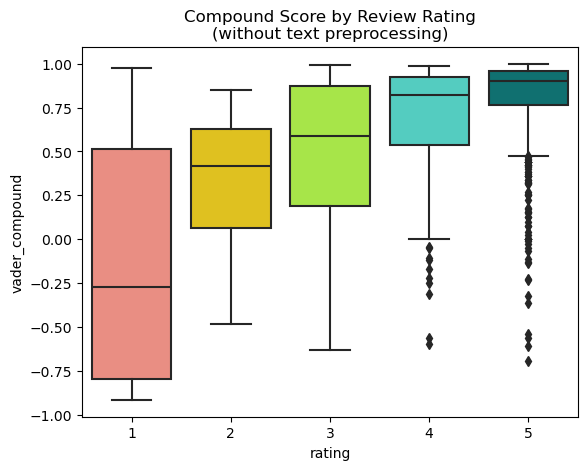

In [129]:
ax = sns.boxplot(data=merged_vader2, x='rating', y='vader_compound', palette=colors)
ax.set_title('Compound Score by Review Rating\n(without text preprocessing)')
plt.show()

In [130]:
# Query the dataFrame for reviews with a 1-star rating and sort by the positive sentiment score in descending order
positive_1_star_vader2 = merged_vader2.query('rating == 1').sort_values('vader_pos', ascending=False).head(3)

# Iterate through the first 3 results and print both the original and preprocessed text
for index, row in positive_1_star_vader2.iterrows():
    print(f"vader_pos: {row['vader_pos']}")
    print(f"Text: {row['review_text']}")

vader_pos: 0.248
Text: i have purchased the full Mielle hair care products after the hype they got, after 2 weeks of use (I barely could use them) i wouldn't recommend them to anyone! before i mention if they help with hair growth i would like to mention how they leave your hair super super greasy even after shampooing multiple times! i even tried to use separately to detect which item causes this grassiness yet it didnt work, your hair would like like you showered with pure oil. i didnt like at all. scent is minty. size is relatively small.
vader_pos: 0.166
Text: Horrible gel. I have fine, curly hair & this was wayyy to heavy for my hair. Also made it very dry, frizzy & sticky feeling. Smell wasn't anything special. Don't use if you have fine hair that gets weighed down easily.
vader_pos: 0.133
Text: I bought the whole range looking forward to go on my hair growth journey but have literally lost so much hair from this brand. It is the only thing I changed and the second I started usin

In [131]:
# Query the dataFrame for reviews with a 5-star rating and sort by the negative sentiment score in descending order
negative_5_star_vader2 = merged_vader2.query('rating == 5').sort_values('vader_neg', ascending=False).head(3)

# Iterate through the first 3 results and print both the original and preprocessed text
for index, row in negative_5_star_vader2.iterrows():
    print(f"vader_neg: {row['vader_neg']}")
    print(f"Text: {row['review_text']}")
    print("----------")

vader_neg: 0.26
Text: No, I haven't received it yet. No, Ingredients, Taste, Usage, Size, Package, Quantity, Like
----------
vader_neg: 0.224
Text: The best product that allowed me to style my curly hair. Now there is no destruction, the hair lies curl to curl. I've been using it for several years now.
----------
vader_neg: 0.2
Text: Crazy bittersweet that softens the hair and makes it fluffy and moisturizes it. Crazy to ask for a lot, and I will come back and order, don't miss it.
----------


# Sentiment Analysis using RoBERTa

RoBERTa (Robustly optimized BERT approach)is a deep learning pre-trained model that employs Transformer architecture for nuanced natural language processing, including sentiment analysis. It outputs logits that, once processed by softmax, yield probabilities for positive, neutral, and negative sentiments. These probabilities, summing up to 1, reflect the model's confidence in the sentiment class of the analyzed text.

Similar to the case of VADER, our findings revealed that RoBERTa's performance on processed text did not meet our anticipated standards, notably when analyzing sentiments from reviews with the lowest ratings of 1 to 2 stars. To explore this divergence, we would also evaluate RoBERTa's accuracy across two scenarios: one with text preprocessing and one without.

## With Text Preprocessing

In [132]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [133]:
# Define a function to get RoBERTa sentiment scores
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    return {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }

In [134]:
# Perform sentiment analysis
result1 = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review_text']
        roberta_result1 = polarity_scores_roberta(text)
        result1[i] = roberta_result1  # Use the index as a unique key
    except RuntimeError:
        print(f'Broke for index {i}')

# Create a DataFrame from the results
roberta1 = pd.DataFrame(result1).T

merged_roberta1 = pd.concat([df, roberta1], axis=1)
insert_position = len(df.columns)-1
merged_roberta1.insert(insert_position, 'original_text', df2['review_text'])

merged_roberta1.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,product_id,rating,original_text,review_text,roberta_neg,roberta_neu,roberta_pos
0,108764,5,The addiction to this shampoo is made up of he...,addition shampoo made hers fell love bought se...,0.031680,0.270978,0.697341
1,108764,5,The smell is sweet. It is not good to use. Two...,smell sweet good use two squeezed enough lot f...,0.011256,0.237943,0.750801
2,108764,5,The smell is acceptable and good to use. I use...,smell acceptable good use use twice week stron...,0.013158,0.213535,0.773307
3,108764,5,The shampoo is so bitter and its smell is swee...,shampoo bitter smell sweet sweet improves smel...,0.033794,0.430182,0.536024
4,108764,5,"The natural scent of herbs is pleasant, and ev...",natural scent hers pleasant even though i'm wa...,0.033422,0.173857,0.792721


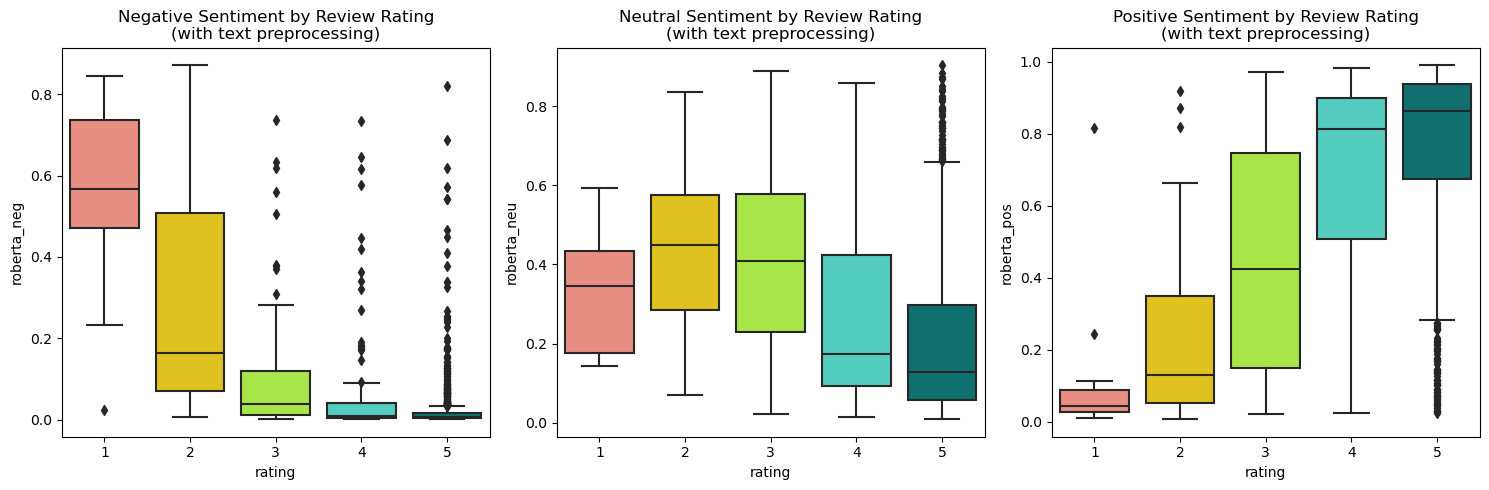

In [135]:
# Create boxplots for each sentiment category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Negative sentiment
sns.boxplot(data=merged_roberta1, x='rating', y='roberta_neg', ax=axes[0], palette=colors)
axes[0].set_title('Negative Sentiment by Review Rating\n(with text preprocessing)')

# Neutral sentiment
sns.boxplot(data=merged_roberta1, x='rating', y='roberta_neu', ax=axes[1], palette=colors)
axes[1].set_title('Neutral Sentiment by Review Rating\n(with text preprocessing)')

# Positive sentiment
sns.boxplot(data=merged_roberta1, x='rating', y='roberta_pos', ax=axes[2], palette=colors)
axes[2].set_title('Positive Sentiment by Review Rating\n(with text preprocessing)')

plt.tight_layout()
plt.show()

In [136]:
# Query the dataFrame for reviews with a 1-star rating and sort by the positive sentiment score in descending order
positive_1_star_roberta1 = merged_roberta1.query('rating == 1').sort_values('roberta_pos', ascending=False).head(3)

# Iterate through the first 3 results and print both the original and preprocessed text
for index, row in positive_1_star_roberta1.iterrows():
    print(f"roberta_pos: {row['roberta_pos']}")
    print(f"Original Text: {row['original_text']}")
    print(f"Preprocessed Text: {row['review_text']}")
    print("----------")

roberta_pos: 0.8160131573677063
Original Text: Now I finally understand the hype! After 3 months of using it I can see baby hair growing out! Noticed a little bit of difference in hair loss but I keep my hopes up after some time! The scent is subtle and doesn’t bother me. My scalp is less itchy. The size is really good and goes for a while if you’re oiling two times to 3 times a week. Looking forward to seeing more improvements in my hair for the next 3 months! Edit; my hair went crazy! I realized it is so heavy for my hair. Became so greasy on the scalp yet so frizzy too! Hair loss increased so I stopped using it.
Preprocessed Text: finally understand hope! 3 month using see baby hair growing out! noticed little bit difference hair loss keep hope time! scent subtle doesn’t bother scalp le itchy size really good go you’re boiling two time 3 time week looking forward seeing improvement hair next 3 months! edit hair went crazy! realized heavy hair became greasy scalp yet friday too! hair

In [137]:
# Query the dataFrame for reviews with a 5-star rating and sort by the negative sentiment score in descending order
negative_5_star_roberta1 = merged_roberta1.query('rating == 5').sort_values('roberta_neg', ascending=False).head(3)

# Iterate through the first 3 results and print both the original and preprocessed text
for index, row in negative_5_star_roberta1.iterrows():
    print(f"roberta_neg: {row['roberta_pos']}")
    print(f"Original Text: {row['original_text']}")
    print(f"Preprocessed Text: {row['review_text']}")
    print("----------")

roberta_neg: 0.0236185435205698
Original Text: Very useful for girls and there is nothing better than iherb products that I recommend ❤️
Preprocessed Text: useful girl nothing better herb product recommend red heart
----------
roberta_neg: 0.02822738140821457
Original Text: Great hold, does not leave it stick or unpleasant. But price has crept up over the year. That's the only downside.
Preprocessed Text: great hold leave stick unpleasant price crept year that's downside
----------
roberta_neg: 0.04685748741030693
Original Text: best gel ever, it never leaves my curls crunchy and it sure hold them until the third day. i feel like the package has become somewhat underwhelming? maybe if put in a container it'd be better. what i also noticed is it never leaves my scalp flaky even when i accidentally apply it on my roots as opposed to other gels i used which caused me dandruff like flakiness.
Preprocessed Text: best get ever never leaf curl crutch sure hold third day feel like package beco

## Without Text Preprocessing

In [138]:
# Perform sentiment analysis
result2 = {}
for i, row in tqdm(df2.iterrows(), total=len(df2)):
    try:
        text = row['review_text']
        roberta_result2 = polarity_scores_roberta(text)
        result2[i] = roberta_result2  # Use the index as a unique key
    except RuntimeError:
        print(f'Broke for index {i}')

# Create a DataFrame from the results
roberta2 = pd.DataFrame(result2).T

merged_roberta2 = pd.concat([df2, roberta2], axis=1)
merged_roberta2.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,product_id,rating,review_text,roberta_neg,roberta_neu,roberta_pos
0,108764,5,The addiction to this shampoo is made up of he...,0.002902,0.041138,0.955960
1,108764,5,The smell is sweet. It is not good to use. Two...,0.235898,0.440339,0.323762
2,108764,5,The smell is acceptable and good to use. I use...,0.002322,0.042706,0.954972
3,108764,5,The shampoo is so bitter and its smell is swee...,0.026306,0.246440,0.727254
4,108764,5,"The natural scent of herbs is pleasant, and ev...",0.007175,0.035233,0.957592


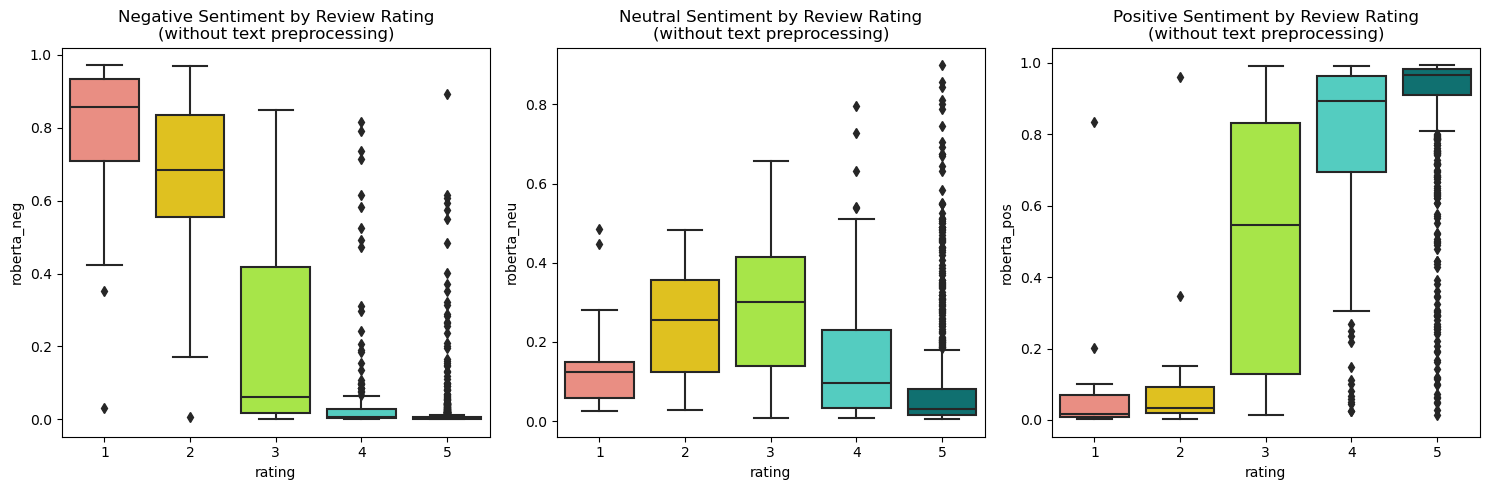

In [139]:
# Create boxplots for each sentiment category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Negative sentiment
sns.boxplot(data=merged_roberta2, x='rating', y='roberta_neg', ax=axes[0], palette=colors)
axes[0].set_title('Negative Sentiment by Review Rating\n(without text preprocessing)')

# Neutral sentiment
sns.boxplot(data=merged_roberta2, x='rating', y='roberta_neu', ax=axes[1], palette=colors)
axes[1].set_title('Neutral Sentiment by Review Rating\n(without text preprocessing)')

# Positive sentiment
sns.boxplot(data=merged_roberta2, x='rating', y='roberta_pos', ax=axes[2], palette=colors)
axes[2].set_title('Positive Sentiment by Review Rating\n(without text preprocessing)')

plt.tight_layout()
plt.show()

In [140]:
# Query the dataFrame for reviews with a 1-star rating and sort by the positive sentiment score in descending order
positive_1_star_roberta2 = merged_roberta2.query('rating == 1').sort_values('roberta_pos', ascending=False).head(3)

# Iterate through the first 3 results and print both the original and preprocessed text
for index, row in positive_1_star_roberta2.iterrows():
    print(f"roberta_pos: {row['roberta_pos']}")
    print(f"Text: {row['review_text']}")
    print("----------")

roberta_pos: 0.834686279296875
Text: Now I finally understand the hype! After 3 months of using it I can see baby hair growing out! Noticed a little bit of difference in hair loss but I keep my hopes up after some time! The scent is subtle and doesn’t bother me. My scalp is less itchy. The size is really good and goes for a while if you’re oiling two times to 3 times a week. Looking forward to seeing more improvements in my hair for the next 3 months! Edit; my hair went crazy! I realized it is so heavy for my hair. Became so greasy on the scalp yet so frizzy too! Hair loss increased so I stopped using it.
----------
roberta_pos: 0.20145849883556366
Text: Initially, it felt like it cleaned the scalp well from buildup of product and sebum. Leaves the hair nice and clean. I noticed my hair becomes slightly oily after some time, however the scalp will not smell funky.. UPDATE: started experiencing massive hair loss after using it for some time.. not sure if it is the shampoo or another rea

In [141]:
# Query the dataFrame for reviews with a 5-star rating and sort by the negative sentiment score in descending order
negative_5_star_roberta2 = merged_roberta2.query('rating == 5').sort_values('roberta_neg', ascending=False).head(3)

# Iterate through the first 3 results and print both the original and preprocessed text
for index, row in negative_5_star_roberta2.iterrows():
    print(f"roberta_neg: {row['roberta_neg']}")
    print(f"Text: {row['review_text']}")
    print("----------")

roberta_neg: 0.8923622965812683
Text: Ohhh I red so many unbelievable reviews but unfortunately it didn’t work for me… First of all the hair gets so greasy and you can only use it if you are home… maybe I was doing something wrong but definitely not for me … the scent is very specific the rest was ok, the package arrived well and the size is good… I guess it’s just not for me
----------
roberta_neg: 0.6168102622032166
Text: Great hold, does not leave it stick or unpleasant. But price has crept up over the year. That's the only downside.
----------
roberta_neg: 0.6069985032081604
Text: Excellent shampoo I ordered for my friend and she gave me 3 boxes, unfortunately the quantity was about to run out and was limited to two boxes only
----------


In our case, we find that both VADER and RoBERTa perform better without text preprocessing. It could be because the raw text contains important cues for sentiment that are either altered or removed during preprocessing. For example, emojis are a rich source of sentiment that VADER can interpret, but they might be altered during preprocessing. Similarly, RoBERTa could be sensitive to the original structure and context of the text, which might be lost after certain preprocessing steps.

On the other hand, we found that the NLTK library's list of stopwords includes negation words, which play a crucial role in sentiment analysis. Stripping these words from the text during preprocessing could adversely affect the accuracy of both VADER and RoBERTa.

# VADER versus RoBERTa

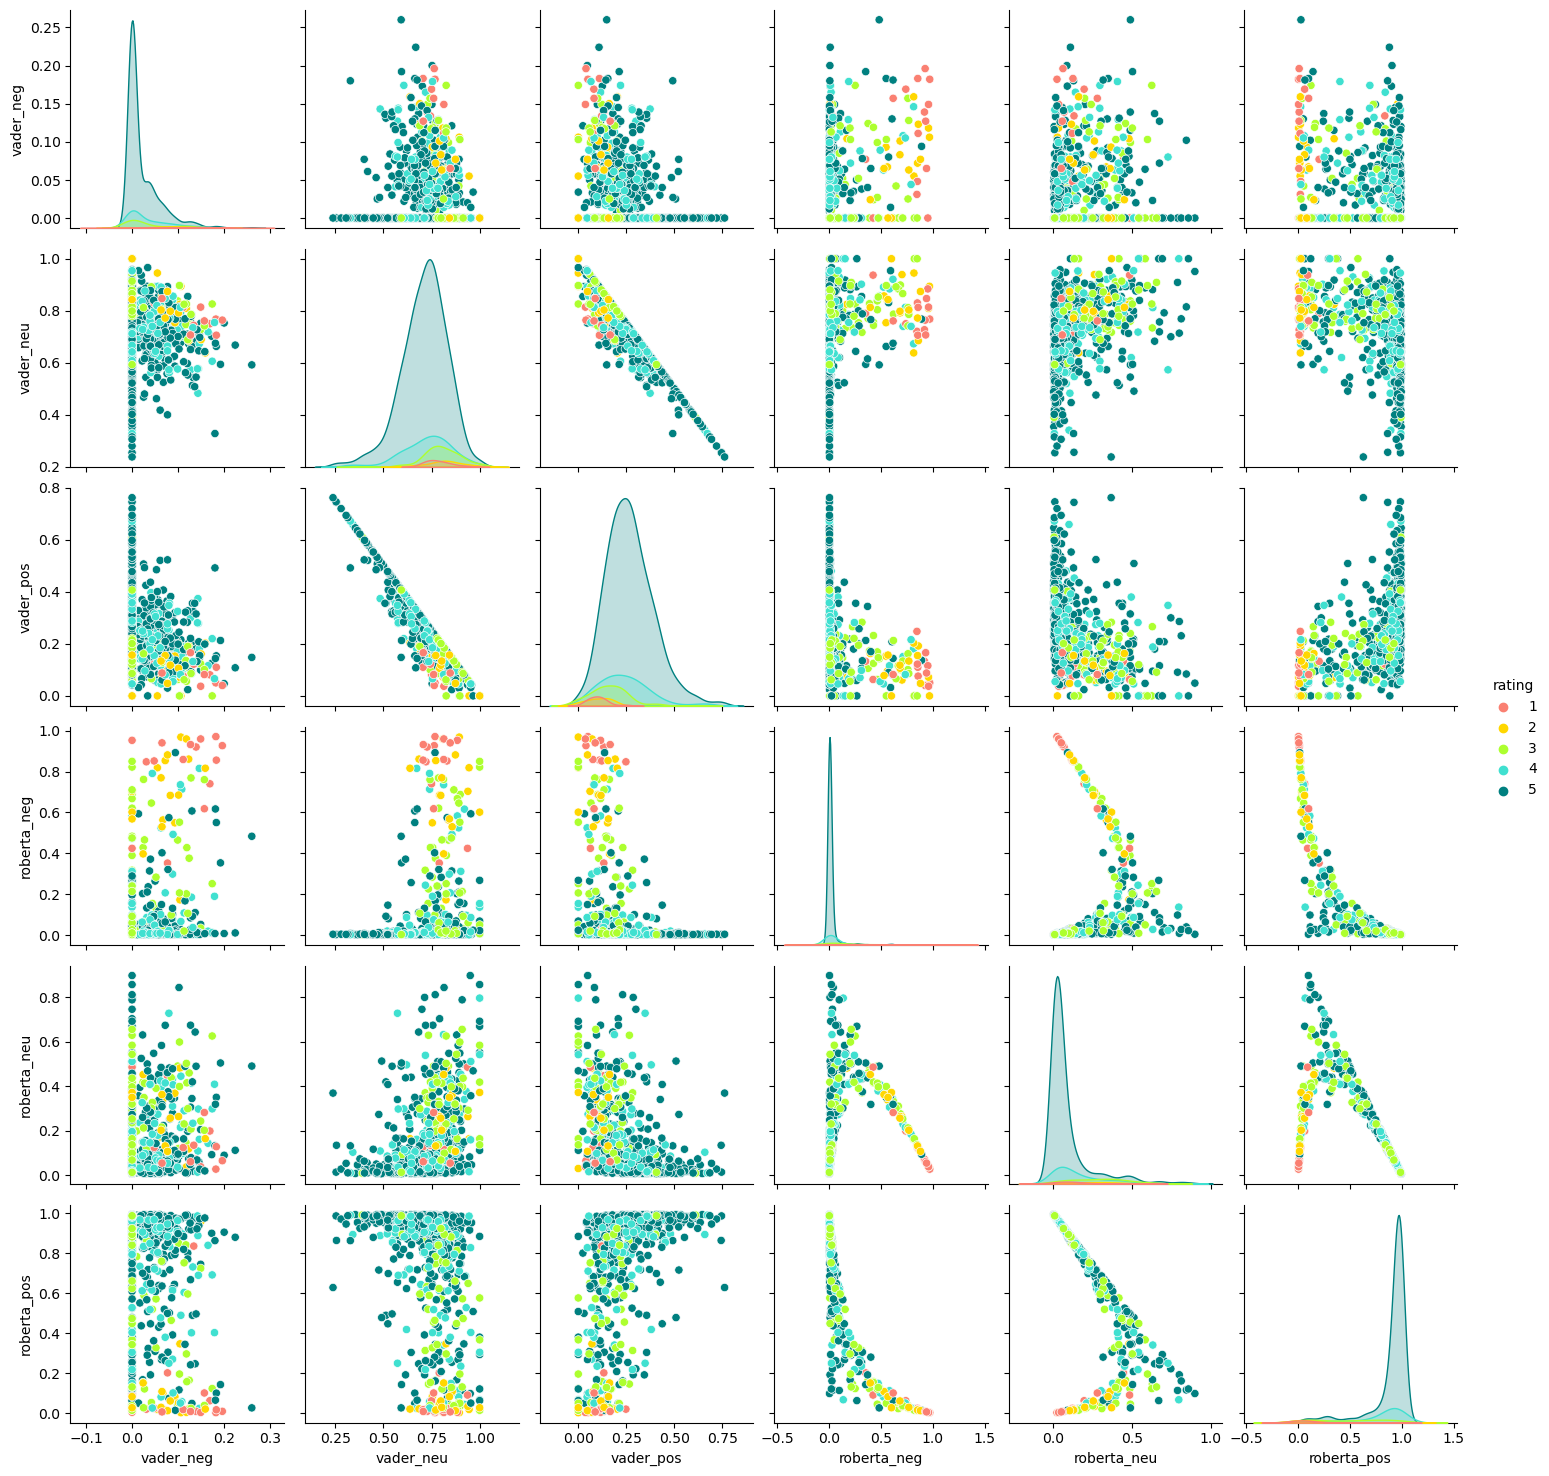

In [142]:
compparison = pd.concat([merged_vader2, roberta2], axis=1)

sns.pairplot(data=compparison,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='rating',
            palette=colors)
plt.show()

RoBERTa appears to have a more concentrated distribution, suggesting more consistent performance across different metrics. Its points are often more tightly clustered, indicating less variability and potentially more reliable performance. In contrast, VADER’s points show more spread, suggesting higher variability in performance. Overall, RoBERTa generally demonstrates more consistent and reliable performance across various metrics compared to VADER.

# Insights from reviews

We define classifcation thresholds which establish the criteria for categorizing sentiment into different classes based on the scores normalized from the resulted logits from RoBERTa.

In [143]:
def classify_sentiment(row):
    neg = row['roberta_neg']
    pos = row['roberta_pos']
    neu = row['roberta_neu']
    
    if pos > 0.75 and neg < 0.25:
        return 'Positive'
    elif pos > 0.5 and neg < 0.5:
        return 'Mild Positive'
    elif pos < 0.25 and neg < 0.25 and neu > 0.5:
        return 'Neutral'
    elif neg > 0.75 and pos < 0.25:
        return 'Negative'
    elif pos < 0.5 and neg > 0.5:
        return 'Mild Negative'
    else:
        return 'Mixed'

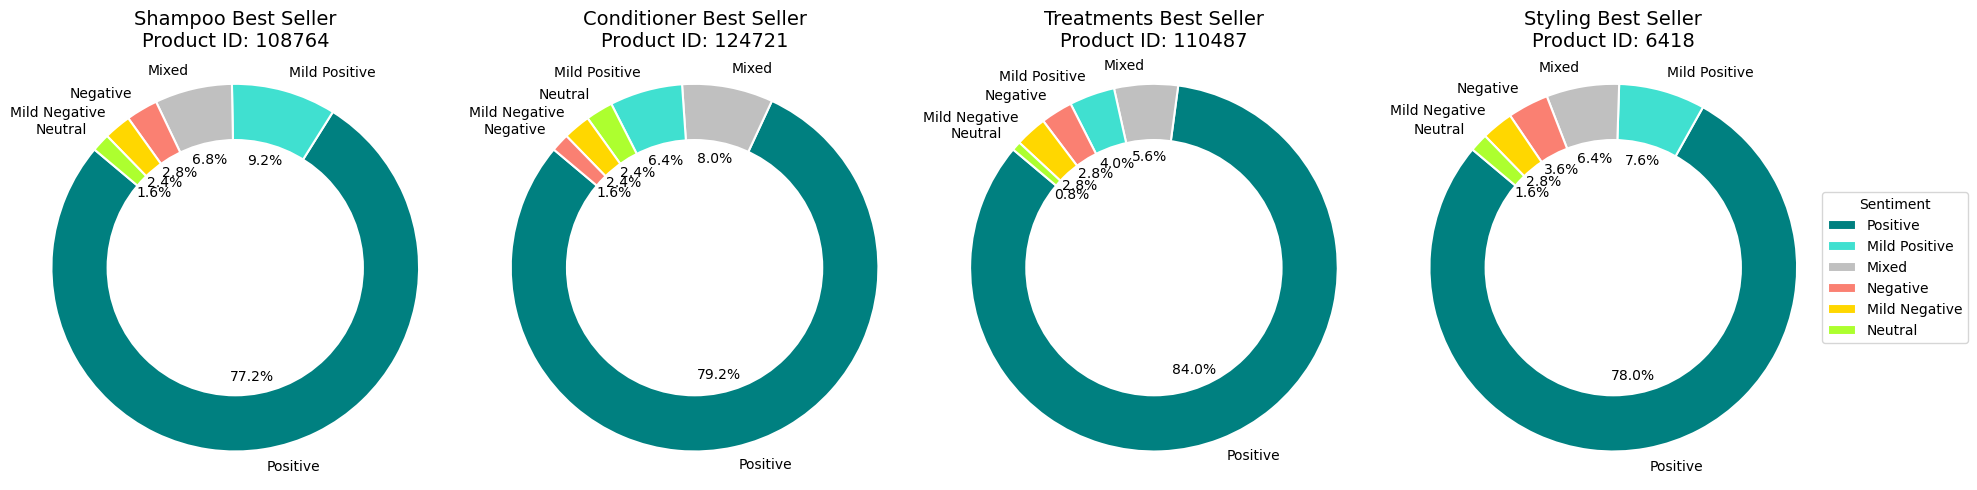

In [144]:
merged_roberta2['sentiment_label'] = merged_roberta2.apply(classify_sentiment, axis=1)

# List of product_ids to visualize
product_ids = [108764, 124721, 110487, 6418]
product_names = ["Shampoo Best Seller", "Conditioner Best Seller", "Treatments Best Seller", "Styling Best Seller"]

# Assign specific colors to each sentiment label
colors = {
    'Positive': 'teal',
    'Mild Positive': 'turquoise',
    'Neutral': 'greenyellow',
    'Mild Negative': 'gold',
    'Negative': 'salmon',
    'Mixed': 'silver'
}

# Set up the subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Set the font size for labels and title
label_fontsize = 12
title_fontsize = 14
tick_fontsize = 12

for ax, product_id, product_name in zip(axes, product_ids, product_names):
    product_data = merged_roberta2[merged_roberta2['product_id'] == product_id]
    
    # Count the frequency of each sentiment label
    sentiment_counts = product_data['sentiment_label'].value_counts()
    
    # Create the pie chart
    wedges, texts, autotexts = ax.pie(sentiment_counts, labels=sentiment_counts.index, colors=[colors[label] for label in sentiment_counts.index],
                                     autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})
    
    # Add title
    ax.set_title(f'{product_name}\nProduct ID: {product_id}', fontsize=title_fontsize)
    
    # Draw circle for donut-like pie chart
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)
    
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal')  
    
# Add a legend
plt.legend(wedges, sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

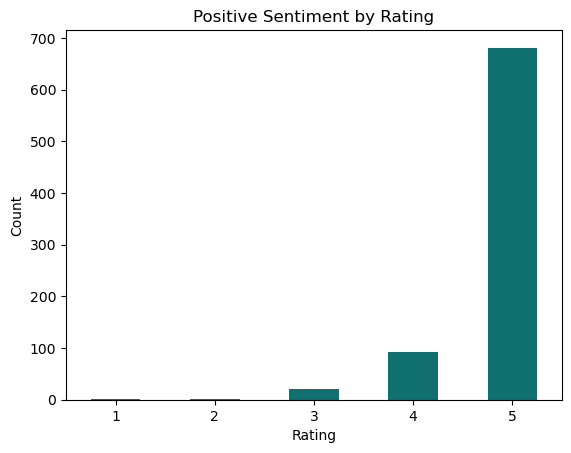

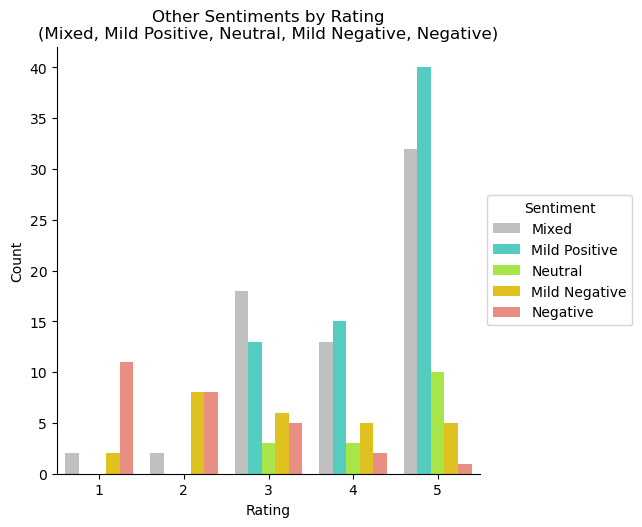

In [145]:
# Filter the dataFrame for only 'Positive' sentiment
positive_reviews = merged_roberta2[merged_roberta2['sentiment_label'] == 'Positive']

# Create a barplot for 'Positive' sentiment by rating
sns.barplot(x='rating', y='count()', data=positive_reviews.groupby('rating').size().reset_index(name='count()'), color=colors['Positive'], width=0.5)
plt.title('Positive Sentiment by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Filter the dataFrame for other sentiment labels
other_labels_reviews = merged_roberta2[merged_roberta2['sentiment_label'].isin(['Mild Positive', 'Neutral', 'Mixed', 'Mild Negative', 'Negative'])]

# Create a catplot for other sentiment labels by rating
sns.catplot(x="rating", hue="sentiment_label", kind="count", data=other_labels_reviews, palette=colors, legend=False)
plt.title('Other Sentiments by Rating\n(Mixed, Mild Positive, Neutral, Mild Negative, Negative)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [146]:
# Most positive review
most_positive_review = merged_roberta2.loc[merged_roberta2['roberta_pos'].idxmax(), 'review_text']
print("Most Positive Review:", most_positive_review)

# Most negative review
most_negative_review = merged_roberta2.loc[merged_roberta2['roberta_neg'].idxmax(), 'review_text']
print("Most Negative Review:", most_negative_review)

Most Positive Review: Wow I loved it so much the color is amazing and the quality of the loosing powder is so nice I’ll definitely will be ordering again. The scent is so nice and the size is great, loved it so much, good packing and packaging loved it too, the coverage is beautiful.
Most Negative Review: I really didn't like the shampoo, my hair is still greasy when I use it, my hair falls out more when I wash it, I don't know how it helps to stop hair loss, I just started losing hair and it made my hair greasy... I think I won't buy it again..


In [147]:
# Get the list of product IDs for mixed sentiment reviews
mixed_product_ids = merged_roberta2[merged_roberta2['sentiment_label'] == 'Mixed']['product_id'].unique()

# Iterate over each product category and print mixed sentiment reviews
for product_id in mixed_product_ids:
    mixed_reviews = merged_roberta2[(merged_roberta2['sentiment_label'] == 'Mixed') & (merged_roberta2['product_id'] == product_id)]
    product_cat = product_categories.get(product_id)
    print(f"Reviews with Mixed Sentiment on the {product_cat}:")
    
    # Iterate over the mixed sentiment reviews and print them with a custom index
    for custom_index, (index, row) in enumerate(mixed_reviews.iterrows(), start=1):
        print(f"{custom_index}: {row['review_text']}")
    print("\n")

Reviews with Mixed Sentiment on the Shampoo Best Seller:
1: The smell is sweet. It is not good to use. Two squeezes of it are enough for a lot of foam. Do not put it on the hair directly. And let the hair breathe, frankly, for my part, I can go back to take two boxes if I finish loving it and take the mask with it. Like if you benefit ❤️
2: This company is taking literally all their products, I have nothing left and I can complete them except for gel. Unfortunately, it is not available to escape. I don’t know where to get it. The important thing is that the shampoo is nice, it lengthens the hair quickly because it contains rosemary and cleans the scalp from the heart that makes you moisturized because I felt it dries the hair even though I just put it on the scalp
3: I am 30 year old.My hair type is frizzy due to dye my hair for years bcz of white hair.and i have used thousand of expensive treatment/shampoos. i almost gave up which can help my frizzy hair ..finally decided to buy this 

# Conclusion

Based on our analysis, we examined the most positive, the most negative, as well as mixed reviews. We found that mixed reviews are more reliable because:

1. Balanced View: They offer a nuanced balance of pros and cons, better reflecting the average customer's experience.

2. Detailed Feedback: Mixed reviews provide in-depth feedback, highlighting both strong points and areas for improvement.

3. Realistic Expectations: They set practical expectations by presenting a product's full range of performance.

4. Trustworthiness: These reviews are often seen as more credible, being neither overly optimistic nor pessimistic.

5. Influence of Ambiguity: They reflect varying outcomes based on individual preferences or use cases.